In [45]:
import cudf
import matplotlib.pyplot as plt
print(cudf.__version__)
import numpy as np
import cupy as cp
import pandas as pd
from tqdm import tqdm

23.04.01


In [22]:
chunk_size = 100000

chunks = []

# read the CSV file in chunks
for chunk in pd.read_csv('/workspaces/wiggle-face/data_ioana/Infant Sentiment Analysis/Ioana/keypoints_dataset.csv', chunksize=chunk_size):
    # pandas DataFrame chunk to cuDF DataFrame
    cudf_chunk = cudf.DataFrame.from_pandas(chunk)
    chunks.append(cudf_chunk)

# concatenate
df = cudf.concat(chunks, ignore_index=True)

print(df.head())

   infant_id  frame_id                                  keypoint  \
0          0         0  (351.60113525390625, 463.11529541015625)   
1          0         0    (358.9483947753906, 466.7889404296875)   
2          0         0    (367.3977355957031, 470.8299255371094)   
3          0         0    (375.1123352050781, 473.4014587402344)   
4          0         0    (384.2964172363281, 476.3403625488281)   

   keypoint_score face_part  keypoint_index  
0        0.577999      Chin               1  
1        0.752206      Chin               2  
2        0.598173      Chin               3  
3        0.759949      Chin               4  
4        0.610798      Chin               5  


In [23]:
# split the keypoint column into 2 columns for the x and y coordinates
df[['x_coordinate', 'y_coordinate']] = df['keypoint'].str.extract(r'\(([^,]+), ([^,]+)\)').astype(np.float64)
df = df.drop(columns=['keypoint'])
df = df.sort_values(by=['infant_id', 'frame_id', 'keypoint_index']).reset_index(drop=True)
    
print(df.head(319))

     infant_id  frame_id  keypoint_score    face_part  keypoint_index  \
0            0         0        0.577999         Chin               1   
1            0         0        0.752206         Chin               2   
2            0         0        0.598173         Chin               3   
3            0         0        0.759949         Chin               4   
4            0         0        0.610798         Chin               5   
..         ...       ...             ...          ...             ...   
314          0         2        0.822511        Mouth             103   
315          0         2        0.773242        Mouth             104   
316          0         2        0.899796   Left_Pupil             105   
317          0         2        0.965537  Right_Pupil             106   
318          0         3        0.466503         Chin               1   

     x_coordinate  y_coordinate  
0      351.601135    463.115295  
1      358.948395    466.788940  
2      367.397736    

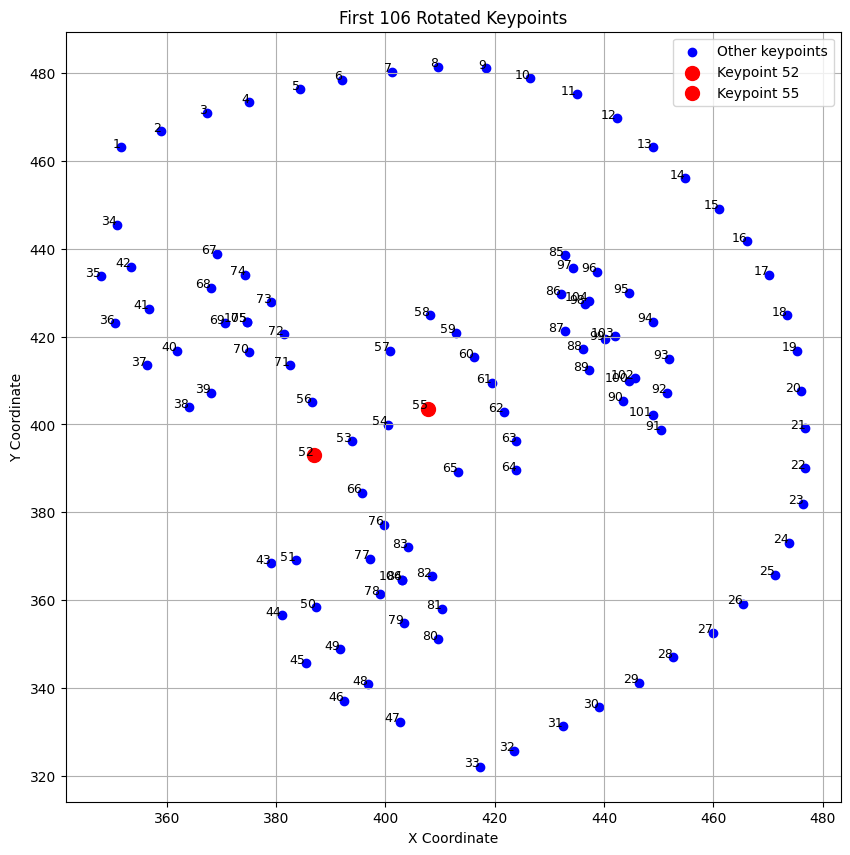

In [24]:
# figure
plt.figure(figsize=(10, 10))
x_coords = df['x_coordinate'][:106].values
y_coords = df['y_coordinate'][:106].values

x_coords = np.array(x_coords.get())
y_coords = np.array(y_coords.get())

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_52_index = 51 
kp_55_index = 54

plt.scatter(x_coords[kp_52_index], y_coords[kp_52_index], c='red', marker='o', label='Keypoint 52', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(106):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')
plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
def move_and_rotate_keypoints(df):
    def get_rotation_matrix(angle):
        return cp.array([
            [-cp.cos(angle), -cp.sin(angle)],
            [cp.sin(angle), -cp.cos(angle)]
        ])

    def rotate_points(points, angle):
        rotation_matrix = get_rotation_matrix(angle)
        return cp.dot(points, rotation_matrix.T)
    
    result = []

    grouped = df.groupby(['infant_id', 'frame_id'])
    
    for (infant_id, frame_id), group in grouped:
        kp_52 = cp.array(group[group['keypoint_index'] == 52][['x_coordinate', 'y_coordinate']].values[0])
        kp_55 = cp.array(group[group['keypoint_index'] == 55][['x_coordinate', 'y_coordinate']].values[0])
        
        translated_coords = cp.array(group[['x_coordinate', 'y_coordinate']].values) - kp_52
        
        dx = kp_55[0] - kp_52[0]
        dy = kp_55[1] - kp_52[1]
        angle = cp.arctan2(dy, dx) - cp.pi / 2
        
        rotated_coords = rotate_points(translated_coords, angle)
        
        transformed_group = group.copy()
        transformed_group[['x_coordinate', 'y_coordinate']] = rotated_coords
        result.append(transformed_group)
    
    return cudf.concat(result).reset_index(drop=True)

transformed_df = move_and_rotate_keypoints(df)
print(transformed_df)

         infant_id  frame_id  keypoint_score    face_part  keypoint_index  \
0                0         0        0.577999         Chin               1   
1                0         0        0.752206         Chin               2   
2                0         0        0.598173         Chin               3   
3                0         0        0.759949         Chin               4   
4                0         0        0.610798         Chin               5   
...            ...       ...             ...          ...             ...   
7860849        369      2699        0.843840        Mouth             102   
7860850        369      2699        0.890791        Mouth             103   
7860851        369      2699        0.839571        Mouth             104   
7860852        369      2699        0.845012   Left_Pupil             105   
7860853        369      2699        0.961737  Right_Pupil             106   

         x_coordinate  y_coordinate  
0           78.529666     -0.384886  

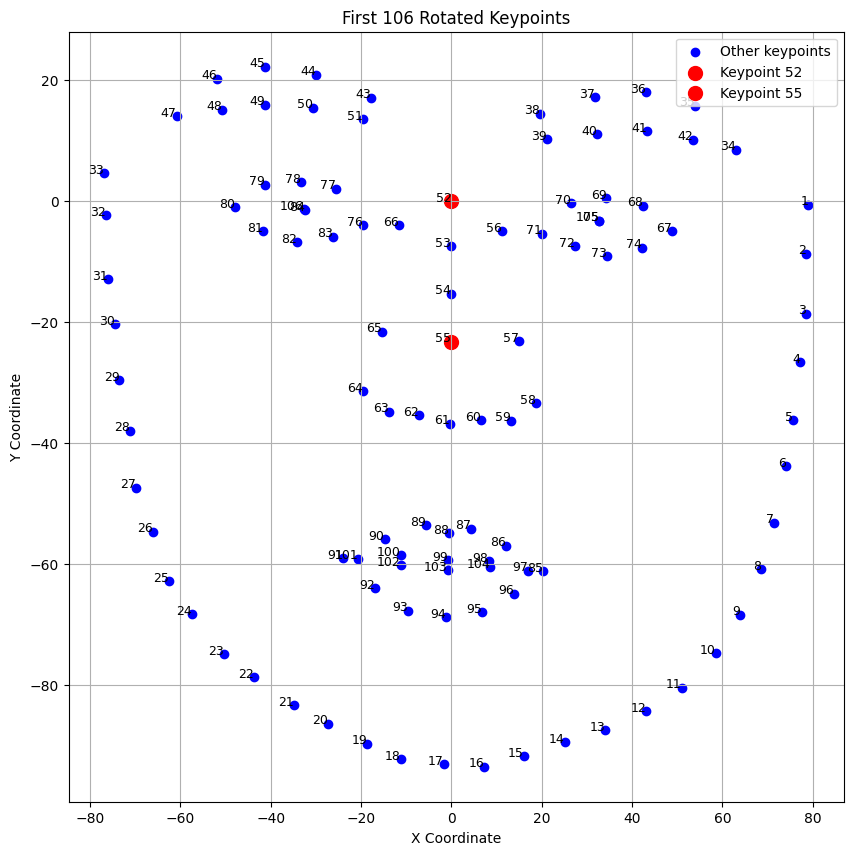

In [36]:
# figure
plt.figure(figsize=(10, 10))

x_coords = transformed_df['x_coordinate'][106:212].values
y_coords = transformed_df['y_coordinate'][106:212].values

x_coords = np.array(x_coords.get())
y_coords = np.array(y_coords.get())

plt.scatter(x_coords, y_coords, c='blue', marker='o', label='Other keypoints')

kp_52_index = 51  
kp_55_index = 54  

plt.scatter(x_coords[kp_52_index], y_coords[kp_52_index], c='red', marker='o', label='Keypoint 52', s=100)
plt.scatter(x_coords[kp_55_index], y_coords[kp_55_index], c='red', marker='o', label='Keypoint 55', s=100)

for i in range(106):
    plt.text(x_coords[i], y_coords[i], str(i+1), fontsize=9, ha='right')

plt.title('First 106 Rotated Keypoints')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.legend()
plt.show()

In [37]:
df.head(107)

,infant_id,frame_id,keypoint_score,face_part,keypoint_index,x_coordinate,y_coordinate
0,0,0,0.577999,Chin,1,351.601135,463.115295
1,0,0,0.752206,Chin,2,358.948395,466.788940
2,0,0,0.598173,Chin,3,367.397736,470.829926
3,0,0,0.759949,Chin,4,375.112335,473.401459
4,0,0,0.610798,Chin,5,384.296417,476.340363
...,...,...,...,...,...,...,...
102,0,0,0.849971,Mouth,103,441.972382,420.133850
103,0,0,0.784512,Mouth,104,437.196655,428.215851
104,0,0,0.866486,Left_Pupil,105,374.744995,423.440125
105,0,0,0.946109,Right_Pupil,106,403.031921,364.662079


In [56]:
# new dataframe with unique infant_id and frame_id combinations
face_feature_df = df[['infant_id', 'frame_id']].drop_duplicates().reset_index(drop=True)

# keypoint indices for the left and right eyebrows
left_brow_indices = cp.array(list(range(34, 43)))
right_brow_indices = cp.array(list(range(43, 52)))
lip_pairs = [(100, 102), (99, 103), (98, 104)]
right_eye_pairs = [(79, 81), (78, 82), (77, 83)]
left_eye_pairs = [(70, 72), (69, 73), (68, 74)]

# dataframe columns to CuPy arrays for keypoints
infant_ids = cp.array(df['infant_id'].values)
frame_ids = cp.array(df['frame_id'].values)
keypoint_indices = cp.array(df['keypoint_index'].values)
y_coords = cp.array(df['y_coordinate'].values)

# func to calculate the mean y-coordinate for specified keypoints
def calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, brow_indices):
    mask = (infant_ids == infant_id) & (frame_ids == frame_id) & (cp.isin(keypoint_indices, brow_indices))
    return y_coords[mask].mean()

# func to calculate the mean distance between specified keypoints
def calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, points):
    distances = []
    for p1, p2 in points:
        mask1 = (infant_ids == infant_id) & (frame_ids == frame_id) & (keypoint_indices == p1)
        mask2 = (infant_ids == infant_id) & (frame_ids == frame_id) & (keypoint_indices == p2)
        kp1 = y_coords[mask1]
        kp2 = y_coords[mask2]
        if kp1.size > 0 and kp2.size > 0:
            distance = cp.abs(kp1 - kp2)
            distances.append(distance)
    return cp.mean(cp.array(distances)) if distances else cp.nan

In [67]:
# calculate mean y-coordinates for the eyebrows with progress tracking
mean_y_coord_left_brow = []
mean_y_coord_right_brow = []

for index in tqdm(range(len(face_feature_df)), desc='Calculating mean y-coordinates for eyebrows'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    
    mean_y_coord_left_brow.append(
        calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, left_brow_indices).get()
    )
    mean_y_coord_right_brow.append(
        calculate_mean_y_coord_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, right_brow_indices).get()
    )

# add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow

print(face_feature_df)


Calculating mean y-coordinates for eyebrows: 100%|██████████| 72532/72532 [04:36<00:00, 262.57it/s]


       infant_id  frame_id  right_eye_eyelid_distance  \
0              0         0                   3.306264   
1              0         1                   3.319336   
2              0         2                   3.212616   
3              0         3                   3.216858   
4              0         4                   3.222148   
...          ...       ...                        ...   
72527        369      2695                   2.220988   
72528        369      2696                   2.377736   
72529        369      2697                   2.198903   
72530        369      2698                   2.176097   
72531        369      2699                   2.193573   

       left_eye_eyelid_distance  lip_distance  right_eye_closed  \
0                      3.918538      0.734731             False   
1                      3.811096      0.737630             False   
2                      3.953990      0.741374             False   
3                      3.959218      0.742350  

In [ ]:
# calculate distances with progress tracking
right_eye_eyelid_distance = []
left_eye_eyelid_distance = []
lip_distance = []

# iterate over each row in the face_feature_df
for index in tqdm(range(len(face_feature_df)), desc='Calculating distances for keypoints'):
    infant_id = face_feature_df['infant_id'].iloc[index]
    frame_id = face_feature_df['frame_id'].iloc[index]
    
    right_eye_eyelid_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, right_eye_pairs).get()
    )
    left_eye_eyelid_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, left_eye_pairs).get()
    )
    lip_distance.append(
        calculate_mean_distance_cp(infant_ids, frame_ids, keypoint_indices, y_coords, infant_id, frame_id, lip_pairs).get()
    )

In [72]:
# add the results back to the dataframe
face_feature_df['mean_y_coord_left_brow'] = mean_y_coord_left_brow
face_feature_df['mean_y_coord_right_brow'] = mean_y_coord_right_brow
face_feature_df['right_eye_eyelid_distance'] = right_eye_eyelid_distance
face_feature_df['left_eye_eyelid_distance'] = left_eye_eyelid_distance
face_feature_df['lip_distance'] = lip_distance

# determine if the eyes and mouth are closed based on the distances
threshold_eyes = 0.8
threshold_mouth =  0.3 
face_feature_df['right_eye_closed'] = face_feature_df['right_eye_eyelid_distance'] < threshold_eyes
face_feature_df['left_eye_closed'] = face_feature_df['left_eye_eyelid_distance'] < threshold_eyes
face_feature_df['mouth_closed'] = face_feature_df['lip_distance'] < threshold_mouth

print(face_feature_df)

       infant_id  frame_id  right_eye_eyelid_distance  \
0              0         0                   3.306264   
1              0         1                   3.319336   
2              0         2                   3.212616   
3              0         3                   3.216858   
4              0         4                   3.222148   
...          ...       ...                        ...   
72527        369      2695                   2.220988   
72528        369      2696                   2.377736   
72529        369      2697                   2.198903   
72530        369      2698                   2.176097   
72531        369      2699                   2.193573   

       left_eye_eyelid_distance  lip_distance  right_eye_closed  \
0                      3.918538      0.734731             False   
1                      3.811096      0.737630             False   
2                      3.953990      0.741374             False   
3                      3.959218      0.742350  

In [73]:
face_feature_df.to_csv('face_features.csv', index=False)

In [75]:
# function to calculate displacement manually
def calculate_manual_displacement(group):
    group['shifted_x'] = group['x_coordinate'].shift(1)
    group['shifted_y'] = group['y_coordinate'].shift(1)

    group['interframe_x_displacement'] = group['x_coordinate'] -  group['shifted_x']
    group['interframe_y_displacement'] =  group['y_coordinate'] - group['shifted_y']

    group['interframe_x_displacement'] = group['interframe_x_displacement'].fillna(0)
    group['interframe_y_displacement'] = group['interframe_y_displacement'].fillna(0)
    
    return group

# displacement for all keypoints
df = df.groupby(['infant_id', 'keypoint_index']).apply(calculate_manual_displacement).reset_index(drop=True)
df = df.drop(columns = ['shifted_x','shifted_y'])
df.loc[df['frame_id'] == 0, ['interframe_x_displacement', 'interframe_y_displacement']] = 0.0

print(df.head(1320))

/opt/miniconda/envs/openmmlab/lib/python3.8/site-packages/cudf/core/groupby/groupby.py:1169: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 6890 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


      infant_id  frame_id  keypoint_score face_part  keypoint_index  \
0             0         0        0.577999      Chin               1   
1             0         1        0.514304      Chin               1   
2             0         2        0.493515      Chin               1   
3             0         3        0.466503      Chin               1   
4             0         4        0.473813      Chin               1   
...         ...       ...             ...       ...             ...   
1315          0      1315        0.711513      Chin               1   
1316          0      1316        0.703581      Chin               1   
1317          0      1317        0.721716      Chin               1   
1318          0      1318        0.754950      Chin               1   
1319          0         0        0.752206      Chin               2   

      x_coordinate  y_coordinate  interframe_x_displacement  \
0       351.601135    463.115295                   0.000000   
1       349.961029   

In [76]:
df.to_csv('displacements.csv', index=False)

In [77]:
mean_displacements = df.groupby(['infant_id', 'keypoint_index'])[['interframe_x_displacement', 'interframe_y_displacement']].mean().reset_index()
mean_displacements.rename(columns={
    'interframe_x_displacement': 'mean_x_displacement_keypoint',
    'interframe_y_displacement': 'mean_y_displacement_keypoint'
}, inplace=True)

# calculating the average confidence per keypoint per infant, based on keypoint_scores 
average_confidence = df.groupby(['infant_id', 'keypoint_index'])['keypoint_score'].mean().reset_index()
average_confidence.rename(columns={'keypoint_score': 'average_confidence_keypoint'}, inplace=True)
face_parts = df[['infant_id', 'keypoint_index', 'face_part']].drop_duplicates()

# merge all metrics
metrics_df = cudf.merge(mean_displacements, average_confidence, on=['infant_id', 'keypoint_index'])
metrics_df = cudf.merge(metrics_df, face_parts, on=['infant_id', 'keypoint_index'])

metrics_df = metrics_df.sort_values(by=['infant_id', 'keypoint_index'])
metrics_df = metrics_df.reset_index(drop=True)

print(metrics_df.head(107))

     infant_id  keypoint_index  mean_x_displacement_keypoint  \
0            0               1                     -0.108792   
1            0               2                     -0.104563   
2            0               3                     -0.100725   
3            0               4                     -0.097220   
4            0               5                     -0.093938   
..         ...             ...                           ...   
102          0             103                     -0.091342   
103          0             104                     -0.090394   
104          0             105                     -0.109413   
105          0             106                     -0.115715   
106          1               1                      0.000633   

     mean_y_displacement_keypoint  average_confidence_keypoint    face_part  
0                        0.010605                     0.495667         Chin  
1                        0.009601                     0.778484         Chin

In [78]:
metrics_df.to_csv('keypoints_metrics.csv', index=False)